# How to optimize your webpage with simple Python code [code]

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta

n_trials = 10000

sns.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [26]:
class Environment:
    """Class for simulating an experiment in whichi multiple options are presented 
    to users. For simulation purposes we set the expected payout to let the sampling
    algorithm find the optimal option across n_trials.
    """
    def __init__(self, options, payouts, n_trials):
        self.options = options
        self.payouts = payouts
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_options = len(options)
        self.shape = (self.n_options, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_option and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_option()
            # Environment returns reward
            # In a real setting this wouldn't exist and the model
            # would be updated directly using the number of successes (presented and clickthrough event) 
            # and failures (presented and no clickthrough event)
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

def plot_k_choices(agent, env):
    cmap = plt.get_cmap("tab10", env.n_options)
    x = np.arange(0, agent.n_trials)
    
    plt.figure(figsize=(30, 12))
    
    plt.scatter(x, agent.option_i.round().astype(int)+1, cmap=cmap, c=agent.option_i.round().astype(int)+1, marker=".", alpha=1)
    plt.title(agent, fontsize=22, fontweight="bold")
    plt.xlabel("Trial", fontsize=22, fontweight="bold")
    plt.xticks(fontsize=15)
    plt.ylabel("Option", fontsize=22, fontweight="bold")
    plt.yticks(fontsize=15)
    plt.yticks(np.array(range(env.n_options))+1)
    plt.colorbar();

In [27]:
class ThompsonSampler:
    """Thompson Sampling using Beta distribution associated with each option.
    The beta distribution will be updated when rewards associated with each option 
    are observed.
    """

    def __init__(self, env, n_learning=0):
        
        # boilier plate data storage
        self.env = env
        self.n_learning = n_learning
        self.options = env.options
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.option_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.option = 0
        self.trial = 0

        # parameters of beta distribution
        self.alpha = np.ones(env.n_options) 
        self.beta = np.ones(env.n_options) 
        # estimated payout rates
        self.theta = np.zeros(env.n_options)
                
    def collect_data(self):
        self.data = pd.DataFrame(dict(option=self.option_i, reward=self.r_i))
        self.n_learning = n_learning
        
    def choose_option(self):
        # sample from posterior (this is the thompson sampling approach)
        # this leads to more exploration because machines with > uncertainty can then be selected as the machine
        self.theta = np.random.beta(self.alpha, self.beta)
        # select machine with highest posterior p of payout
        if self.trial < self.n_learning:
            self.option = np.random.choice(self.options)
        else:
            self.option = self.options[np.argmax(self.theta)]
        return self.option
    
    def update(self):
       
        #update dist (a, b) = (a, b) + (r, 1 - r) 
        # a,b are the alpha, beta parameters of a Beta distribution
        self.alpha[self.option] += self.reward
        # i.e. only increment b when it's a swing and a miss. 1 - 0 = 1, 1 - 1 = 0
        self.beta[self.option] += 1 - self.reward 
        
        # store the option presented on each trial
        self.thetas[self.trial] = self.theta[self.option]

        self.option_i[self.trial] = self.option
        self.r_i[self.trial] = self.reward
        self.trial += 1
    
    def collect_data(self):
        self.data = pd.DataFrame(dict(option=self.option_i, reward=self.r_i))
    
    def __str__(self):
        return "ThompsonSampler"

In [28]:
options_and_payouts = {
    "option-1" : 0.07,
    "option-2" : 0.05,
    "option-3" : 0.04,
    "option-4" : 0.01
}

In [29]:
machines = [0, 1, 2, 3]
payouts = [0.07, 0.05, 0.04, 0.01]
labels = ["V" + str(i) + (str(p)) for i, p in zip(machines, payouts)]
assert len(machines) == len(payouts)

In [33]:
en2 = Environment(machines, payouts, 1000)
tsa = ThompsonSampler(env=en2)
en2.run(agent=tsa)

tsa.data.option.value_counts()

0.0    823
2.0     74
3.0     52
1.0     51
Name: option, dtype: int64

<Figure size 1008x504 with 0 Axes>

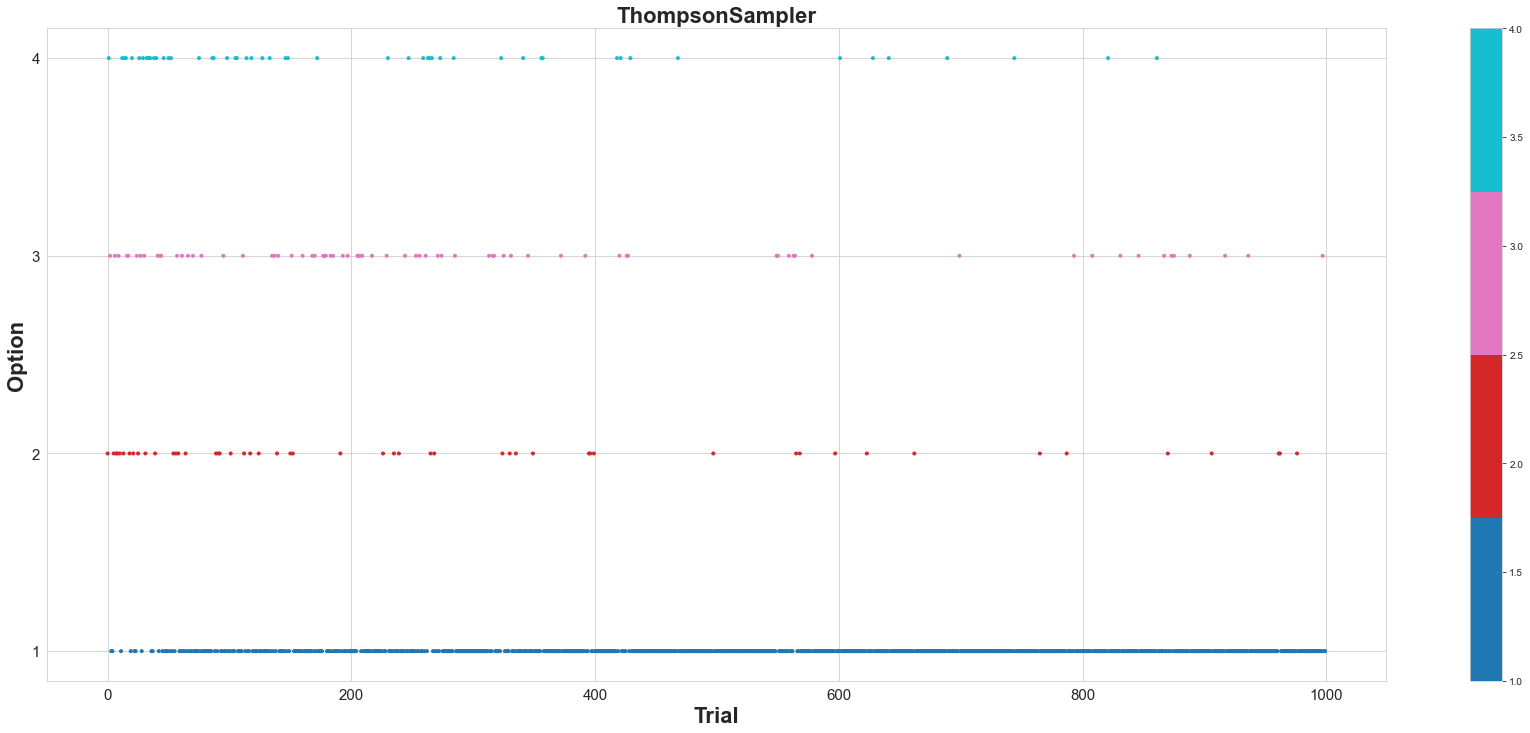

In [34]:
plt.figure(figsize=(14, 7))
plot_k_choices(tsa, en2);

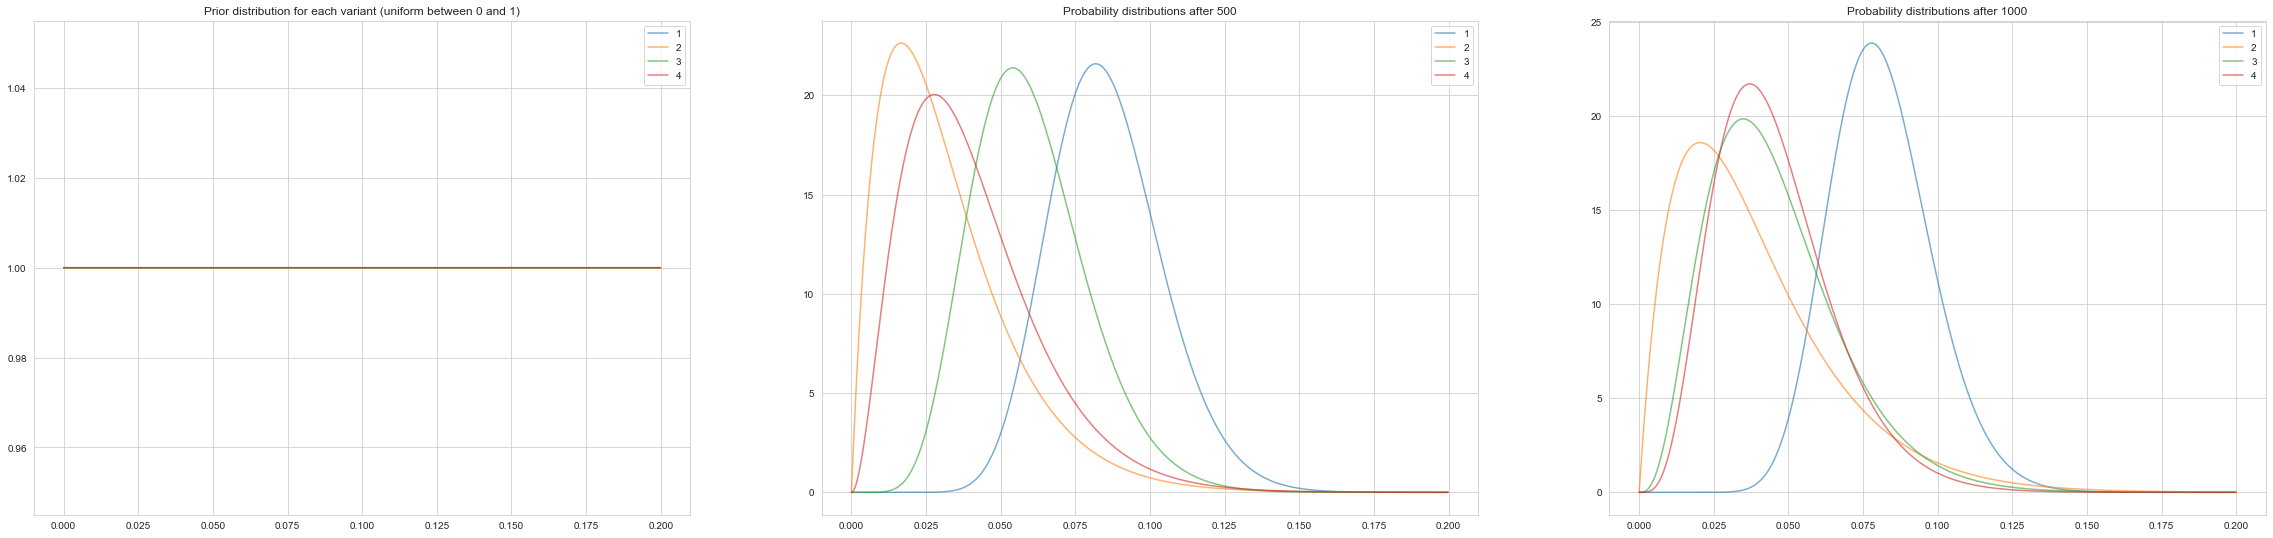

In [11]:

x = np.arange(0, .2, 0.0001)
cmap = list(plt.cm.tab10(list(range(len(machines)))))

plt.figure(figsize=(40, 20))

# plot 1
n_rounds = 0
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
plt.subplot(231)
for i in range(len(machines)):
    pdf = beta(tsa.alpha[i], tsa.beta[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i+1, alpha=.6)
plt.title(f"Prior distribution for each variant (uniform between 0 and 1)")
plt.legend();

# plot 2
n_rounds = 500
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
plt.subplot(232)
for i in range(len(machines)):
    pdf = beta(tsa.alpha[i], tsa.beta[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i+1, alpha=.6)
plt.title(f"Probability distributions after {n_rounds}")
plt.legend();

# plot 3
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 1000
plt.subplot(233)
for i in range(len(machines)):
    pdf = beta(tsa.alpha[i], tsa.beta[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i+1, alpha=.6)
plt.title(f"Probability distributions after {n_rounds}")
plt.legend();
